In [2]:
%matplotlib inline
import logging
import numpy as np
import pandas as pd
import geopandas
import glob
import os
from pyorbital import astronomy
from datetime import datetime, timedelta
from shapely import geometry

## Data Preparation

In [3]:
def compute_sun_glint_angle(sat_angle):
    """Compute the sun glint angle. Sun glint angle is defined as the angle difference between reflected solar beam and
    the satellite view/zenith angle, from the satellite reference frame. If the angle is small, it means that the
    reflected solar beam is seen by the satellite as sun glint.

    The eqn of sun glint is
        cos (theta_g) = cos (theta_v) * cos (theta_s) - sin (theta_v) * sin (theta_s) * cos (phi), where
        theta_g = sun glint angle, theta_v = satellite view/zenith angle, theta_s = solar zenith angle,
        phi = relative azimuth angle (difference between solar and satellite azimuth angle)

    For more info, refer to "An Enhanced Contextual Fire Detection Algorithm for MODIS" by Louis Giglio et al 2003
    https://doi.org/10.1016/S0034-4257(03)00184-6

    Args:
        sat_angle (dict): Dict of satellite angles: {
                        'viewzenang' (float): satellite view/zenith angle,
                        'solarzenang' (float): solar zenith angle,
                        'relazang' (float): relative azimuth angle ,
                         }

    Returns:
        sun_glint_angle (float): Angle of sun glint in degrees

    """
    theta_v = np.radians(sat_angle['viewzenang'])
    theta_s = np.radians(sat_angle['solarzenang'])
    phi = np.radians(sat_angle['relazang'])
    cos_sunglint = np.cos(theta_v) * np.cos(theta_s) - (np.sin(theta_v) * np.sin(theta_s) * np.cos(phi))
    sun_glint_rad = np.arccos(cos_sunglint)
    sun_glint_angle = np.degrees(sun_glint_rad)

    return sun_glint_angle

In [4]:
def parse_jaxa_hotspot_txt(file_path):
    """
    Parse the JAXA Himawari-8/9 AHI hotspot text file and insert attrs into the Pandas DataFrame

    Args:
        file_path (str): File path to the JAXA Himawari-8/9 hotspot .csv
          
    Returns:
        hs_df (obj): DataFrame obj that contains attr of Himawari-8/9 hospot
        
    """
    hs_ahi_df = pd.DataFrame()
    cols_to_use_list = [0, 2, *(i for i in range(7,27))]
    date_col_list = [0]
    names_list = ['date', 'satellite', 'lon', 'lat', 'viewzenang', 'viewazang', 'pixwid', 'pixlen', 't07',   
                  't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 
                  'ref3', 'ref4', 'fire_idx', 'fire', 'test1_6']
        

    for file in glob.glob(file_path):
            
        try:
            print (f'Reading {file}')
            temp_hs_ahi_df = pd.read_csv(file, sep=",", skiprows=[0], \
                                         header=None, usecols=cols_to_use_list, \
                                         names=names_list, \
                                         parse_dates=date_col_list)
            temp_hs_ahi_df['satellite'] = 'Himawari-8/9'
        except Exception as e:
            print (f'Error reading {file}')
            print (e)
            continue

        if len(temp_hs_ahi_df) > 0:
                   
            try:
                temp_hs_ahi_df['solarazang'] = temp_hs_ahi_df.apply( \
                    lambda x: np.degrees(astronomy.get_alt_az(x['date'], x['lon'], x['lat'])[1]), axis=1)
                temp_hs_ahi_df['solarzenang'] = temp_hs_ahi_df.apply( \
                    lambda x: astronomy.sun_zenith_angle(x['date'], x['lon'], x['lat']), axis=1)
                temp_hs_ahi_df['relazang'] = temp_hs_ahi_df['solarazang'] - temp_hs_ahi_df['viewazang']
                temp_hs_ahi_df['sunglint_angle'] = temp_hs_ahi_df.apply(compute_sun_glint_angle, axis=1)
            except Exception as e:
                temp_hs_ahi_df['sunglint_angle'] = np.nan
                
            try:
                temp_hs_ahi_df.loc[(temp_hs_ahi_df['date'].dt.hour >= 0) \
                                   & (temp_hs_ahi_df['date'].dt.hour <= 11), 'daynight'] = 'day'
                temp_hs_ahi_df.loc[temp_hs_ahi_df['date'].dt.hour > 11, \
                                   'daynight'] = 'night'
                temp_hs_ahi_df['date'] = temp_hs_ahi_df['date'].dt.strftime( \
                    "%d/%m/%Y %H:%M:%S")
            except Exception as e:
                date_from_file = datetime.strptime(filename[4:17], "%Y%m%d_%H%M")
                temp_hs_ahi_df['date'] = date_from_file.strftime("%d/%m/%Y %H:%M:%S")

        hs_ahi_df = pd.concat([hs_ahi_df, temp_hs_ahi_df])

    if len(hs_ahi_df) > 0:
        hs_ahi_df = hs_ahi_df.reset_index(drop=True)

    return hs_ahi_df

In [ ]:
hs_df_apr = parse_jaxa_hotspot_txt(file_path="../../data/raw/hotspots/ahi/H08_20190[4]*_0[2-7]*_L2WLFbet_FLDK*.csv")

In [ ]:
hs_df_sep = parse_jaxa_hotspot_txt(file_path="../../data/raw/hotspots/ahi/H08_20190[9]*_0[2-7]*_L2WLFbet_FLDK*.csv")

In [ ]:
hs_df =  pd.concat([hs_df_apr, hs_df_sep])

In [4]:
hs_df = pd.read_csv("../../data/raw/hotspots/pd_df_ahi_apr_sep_2019.csv")

In [5]:
hs_df['date'] = pd.to_datetime(hs_df['date'], format='%d/%m/%Y %H:%M:%S')

The ground truth data is collected based on satellite imageries from TERRA, Sentinel-2, NPP, AQUA, NOAA-20 imageries. We make the following assumptions:

* Fire persists non-stop from 0230 to 0730 UTC

Thus, we only look at fire hotspot data in between this period for validation and training.

In [6]:
from datetime import time, datetime
start_time = time(2, 30, 0)
end_time = time(7, 30, 0)
time_filter = (hs_df['date'].dt.time >= start_time) & (hs_df['date'].dt.time <= end_time)
hs_df_short = hs_df[time_filter]

In [7]:
hs_df_short.reset_index(inplace=True, drop=True)

In [8]:
#convert to GeoDataFrame
hs_gdf = geopandas.GeoDataFrame(hs_df_short, geometry=geopandas.points_from_xy(hs_df_short.lon, hs_df_short.lat))

In [9]:
#Change to Mercator (metres) projection as we need to adjust the buffer in metres
hs_gdf.crs = {'init': 'epsg:4326'}
hs_gdf = hs_gdf.to_crs({'init': 'epsg:3857'})

`overlay` only works when for polygon-polygon and not for point-polygon pair. Thus we need to convert the hotspot point coordinate to a polygon.

In [10]:
#convert point to polygon
hs_gdf.geometry = hs_gdf.buffer(1)

In [11]:
truth_df = pd.read_csv('../../references/ground_truth/processed/daily_ground_truth_Apr_Sep_2019.csv')

In [12]:
truth_df.head()

,Unnamed: 0,datestamp,geometry,lat,lon,end_date,start_date,period
0,0,2019/09/01,POINT (11371379.4241247 47734.60307035755),0.428803,102.150839,2019-09-01,2019-09-01,0 days 00:00:00.000000000
1,1,2019/09/01,POINT (11371513.1889242 47386.80492229513),0.425679,102.152041,2019-09-01,2019-09-01,0 days 00:00:00.000000000
2,2,2019/09/01,POINT (11399898.0793779 -14065.19130801257),-0.126350,102.407027,2019-09-01,2019-09-01,0 days 00:00:00.000000000
3,3,2019/09/01,POINT (11399068.73762101 -13984.93223427522),-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000
4,4,2019/09/01,POINT (11400433.1385759 -14038.43828318712),-0.126109,102.411833,2019-09-01,2019-09-01,0 days 00:00:00.000000000


In [13]:
truth_df.drop(columns=["Unnamed: 0"], inplace=True)
#convert ground truth data to Geo DataFrame
truth_gdf = geopandas.GeoDataFrame(truth_df, geometry=geopandas.points_from_xy(truth_df.lon, truth_df.lat))

In [14]:
truth_gdf.crs = {'init' :'epsg:4326'}
truth_gdf = truth_gdf.to_crs({'init': 'epsg:3857'})

The native resolution of AHI fire hotspot is 2km. We assume that buffer of 1 km is acceptable for verification.

In [15]:
truth_gdf_buffered = truth_gdf.buffer(1000)

In [16]:
truth_gdf.geometry = truth_gdf_buffered

In [17]:
#area of interest
clip_area = geopandas.read_file('../../references/ground_truth/shapefile/aoi.shp')
clip_area = clip_area.to_crs({'init': 'epsg:3857'})
clip_area.crs

{'init': 'epsg:3857'}

In [18]:
#clip and remove hotspots outside of aoi
hs_df_clipped = geopandas.overlay(clip_area, hs_gdf, how='intersection')

In [19]:
hs_df_clipped.to_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped.geojson', driver='GeoJSON')

## Data Preparation: Merging Ground Truth Data with Hotspot Data

In [20]:
hs_df_clipped = geopandas.read_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped.geojson', driver='GeoJSON')
truth_gdf['id_truth'] = truth_gdf.index

In [21]:
#overlay both groundtruth and AHI hotspot data
combined_gdf = geopandas.overlay(truth_gdf, hs_df_clipped, how='union')
combined_gdf.head()

,datestamp,lat_1,lon_1,end_date,start_date,period,id_truth,id,Unnamed: 0,date,...,solarazang,solarzenang,sunglint_angle,t07,t07_t14,t14,test1_6,viewazang,viewzenang,geometry
0,2019/09/01,-0.125629,102.399577,2019-09-01,2019-09-01,0 days 00:00:00.000000000,3.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
1,2019/09/06,-0.124484,102.395798,2019-09-06,2019-09-06,0 days 00:00:00.000000000,1075.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
2,2019/09/06,-0.127922,102.401987,2019-09-06,2019-09-06,0 days 00:00:00.000000000,1076.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
3,2019/09/08,-0.115421,102.405331,2019-09-08,2019-09-08,0 days 00:00:00.000000000,1326.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."
4,2019/09/17,-0.111719,102.397897,2019-09-17,2019-09-17,0 days 00:00:00.000000000,6622.0,1.0,180228.0,2019-09-08T04:30:00,...,58.045181,11.247394,54.161539,320.17,21.98,298.19,'011000',89.87,44.35,"POLYGON ((11399116.857 -13358.349, 11399116.85..."


In [22]:
combined_gdf.drop(columns='id', inplace=True)

In [23]:
combined_gdf.rename(columns={'lat_1': 'lat_gt', 'lon_1': 'lon_gt', 'lat_2': 'lat', 'lon_2': 'lon', 'Unnamed: 0': 'id_hs'}, inplace=True)

In [24]:
combined_gdf.to_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped_gtruth_union.geojson', driver='GeoJSON')

## Data Preparation: Cleaning Combined Data

In [3]:
#read in dataframe consists of uncleaned ground truth and raw AHI hotspot detection
combined_gdf = geopandas.read_file('../../data/interim/h8_ml_apr_sep_2019_hs_clipped_gtruth_union.geojson')

In [4]:
#check if ground truth date is valid
combined_gdf['datestamp'].unique()

array(['2019-09-01', '2019-09-06', '2019-09-08', '2019-09-17',
       '2019-09-03', '2019-09-07', '2019-09-20', '2019-09-04',
       '2019-09-05', '2019-09-02', '2019-09-10', '2019-09-12',
       '2019-09-26', '2019-09-11', '2019-09-14', '2019-09-22',
       '2019-09-30', '2019-09-19', '2019-09-16', '2019-09-13',
       '2019-09-18', '2019-09-29', '2019-09-24', '2019-09-21',
       '2019-09-23', '2019-09-09', '2019-09-28', '2019-09-15',
       '2019-09-25', '2019-09-27', '2019-04-01', '2019-04-14',
       '2019-04-18', '2019-04-04', '2019-04-05', '2019-04-06',
       '2019-04-08', '2019-04-24', '2019-04-11', '2019-04-17',
       '2019-04-12', '2019-04-20', '2019-04-13', '2019-04-09',
       '2019-04-02', '2019-04-15', '2019-04-03', '2019-04-19',
       '2019-04-23', '2019-04-22', '2019-04-26', '2019-04-10',
       '2019-04-21', '2019-04-07', '2019-04-16', '2019-04-29',
       '2019-04-30', '2019-04-25', '2019-04-28', '2019-04-27', None],
      dtype=object)

In [5]:
combined_gdf['date'] = pd.to_datetime(combined_gdf['date'])

In [6]:
#initialize with nan
combined_gdf['truth_flag'] = np.nan

In [7]:
#remove data points if date of detected hs is not the same as date of ground truth data
filter_valid_union = combined_gdf['date'].notna() & combined_gdf['datestamp'].notna()
filter_same_date = combined_gdf['date'].dt.strftime('%Y-%m-%d') == combined_gdf['datestamp']
combined_gdf_clean = combined_gdf.drop(combined_gdf[filter_valid_union & (~filter_same_date)].index, axis=0)

In [8]:
#set flag of label coinciding hotspots with same date to 1
combined_gdf_clean.loc[combined_gdf_clean['date'].dt.strftime('%Y-%m-%d') == combined_gdf_clean['datestamp'], 'truth_flag'] = 1
#Set to -1 for missed detections
combined_gdf_clean.loc[combined_gdf_clean['id_hs'].isna(), 'truth_flag'] = -1

In [9]:
#Set to 0 for false alarm
combined_gdf_clean.loc[combined_gdf_clean['id_truth'].isna(), 'truth_flag'] = 0

In [10]:
#get hits and false alarm, avoid double counting of hits (only count as one hit even if hs coincides with multiple ground truth)
combined_gdf_clean_hits_falsealarms = combined_gdf_clean.drop_duplicates(subset=['id_hs'], keep='first')

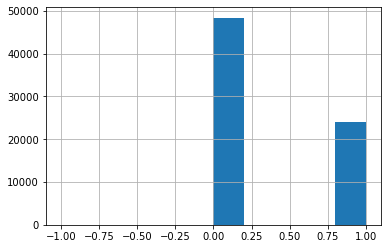

In [12]:
combined_gdf_clean_hits_falsealarms['truth_flag'].hist()

In [13]:
#If a ground truth data has been identified as a hit, it shouldn't be considered as a missed detection anymore. 
#special handling due to union operation, get the list of ground truth data which has been identified as a hit
hits_id_truth_list = combined_gdf_clean_hits_falsealarms.loc[combined_gdf_clean_hits_falsealarms['truth_flag'] == 1, 'id_truth'].unique()

In [14]:
#get missed detections
combined_gdf_clean_missed_detections = combined_gdf_clean[combined_gdf_clean['id_hs'].isna()].copy()
#remove redundant ground truth data misidentified as missed detections
combined_gdf_clean_missed_detections = combined_gdf_clean_missed_detections[~combined_gdf_clean_missed_detections['id_truth'].isin(hits_id_truth_list)].copy()

In [15]:
combined_gdf_clean_dup_removed = pd.concat([combined_gdf_clean_hits_falsealarms, combined_gdf_clean_missed_detections]).drop_duplicates()

In [16]:
#check if double count missed detection or not
try:
    assert combined_gdf_clean_dup_removed[combined_gdf_clean_dup_removed['id_hs'].isna()].duplicated(subset=['id_truth'], keep=False).sum() == 0.0
    print ('Data is clean. No double counting of missed detections.')
except:
    print ('There are duplicated records!')

Data is clean. No double counting of missed detections.


In [17]:
#check if there are no misclassified missed detections
try:
    assert combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed['id_truth'].isin(hits_id_truth_list), 'id_hs'].isna().sum() == 0.0
    print ('Data is clean. No misclassified missed detections.')
except:
    print ('There are duplicated records!')

Data is clean. No misclassified missed detections.


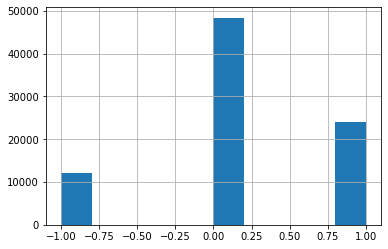

In [18]:
combined_gdf_clean_dup_removed['truth_flag'].hist()

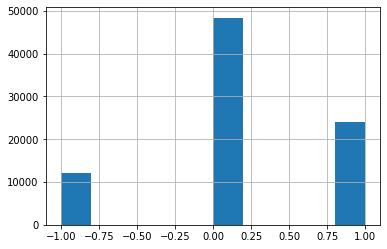

In [201]:
combined_gdf_clean_dup_removed['truth_flag'].hist()

In [203]:
combined_gdf_clean_dup_removed.to_file('../../data/interim/h8_ml_apr_sep_2019_clean.geojson', driver='GeoJSON')